# Minimum Spanning Tree

We will be trying to find the minimum spanning tree of all nodes over Piedmont in California 

We will be implementing kruskal's algorithm, which find the minimum spanning tree over each connected component in out graph

Here is somethings you need to think about when you are doing this algorithm over a graph contructed from a map

- The graph may seem like a one big connected component but it actually isn't. Because there are one-way streets which seem to connect the adjacent nodes on the below graph, but they don't because for example you can get from A to B but you can't get from B to A.

- That is why you will find multiple spanning tree at the end. Over each *connected* streets/neighbourhood of nodes.

- You will find loops in the spanning tree which is the biggest violation of tree-like structure, but you need to think about one-way and two-way street as I mentioned above. It may seem like a loop to you but it is just a one-way street

In [ ]:
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;

# you HAVE to upload problem.py file 
# so the directory should be 
#|- sample_data/ 
#|- problem.py

In [1]:
import networkx as nx
import osmnx as ox
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
from problem import *
from utils import *

In [ ]:
place = 'Piedmont, California, USA'
G = ox.graph_from_place(place, network_type='drive_service')
G = ox.project_graph(G)

In [ ]:
fig, ax = ox.plot_graph(G)

We will be getting x,y coordinates of each nodes for visulaization at the end

In [ ]:
node_Xs = [float(x) for _, x in G.nodes(data='x')]
node_Ys = [float(y) for _, y in G.nodes(data='y')]

In [ ]:
# tuple (source, destination, distance)
Edges = PriorityQueue('min', lambda edge: edge[2])   

In [ ]:
for source, destination, data in G.edges(keys=False, data=True):
    Edges.append((source, destination, data['length']))

We need to maintan disjoint set for the edges and nodes to keep track of what node is connected to what node and avoid loops

In [ ]:
# disjoint set for the edges
nodes_set = {}
for i in Edges.heap:
    nodes_set[i[1][0]] = -1
    nodes_set[i[1][1]] = -1

In [ ]:
# returns -1 if the node has not been attached to other node on the run time
def find_parent(node):
    r = node
    while nodes_set[r] >= 0:
        r = nodes_set[r]
    return r

# The Algorithm

In [ ]:
# super easy if you spend 5 mins thinking about it
# the premise of the algorithm is just to avoid loop
# and add edges greedily
# The algorithm build forestS over each connected component in the graph
# which will diverge to a single tree over each component at the end of the algorithm
Forest = set()
Size = 0
j = 0
m = len(Edges)
n = len(G.nodes)
while Size < n and j < m:
    j += 1
    # the shortest edge till this point
    edge = Edges.pop()
    node1 = edge[0]
    node2 = edge[1]
    parent1 = find_parent(node1)
    parent2 = find_parent(node2)
    if parent1 != parent2:
        Forest.add(edge)
        Size += 1
        nodes_set[node1] = node2

# Visulaization

In [ ]:
sources = [edge[0] for edge in Forest]
destinations = [edge[1] for edge in Forest]

In [ ]:
fig, ax =  plt.subplots(figsize=(15, 11))
ax.set_facecolor('w')
lines = []
colorS = []
widthS = []
for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data:
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)
        if u in sources and v in destinations:
            colorS.append('b')
            widthS.append(2.5)
            continue
        if v in sources and u in destinations:
            colorS.append('b')
            widthS.append(2.5)
            continue
        colorS.append('r')
        widthS.append(0.4)    
lc = LineCollection(lines, colors=colorS, linewidths=widthS, alpha=0.3)
ax.add_collection(lc)
scat = ax.scatter(node_Xs, node_Ys,c='k', s=5)

These loops which you are seeing and these many components over the graph are caused by the presence of one-way streets, don't let it fool you.

In [108]:
MAP = UndirectedGraph(dict(
    A=dict(B=10, C=5, D=3, E=4),
    B=dict(C=2, F=6),
    C=dict(E=11, F=3, G=2),
    D=dict(E=3, H=5),
    E=dict(H=1, G=5),
    F=dict(G=2, J=13, I=7),
    G=dict(H=4, I=3),
    H=dict(I=6),
    I=dict(J=2),
    J=dict()))

In [109]:
MAP.locations = dict(
    A=(90, 450), B=(130, 550), C=(150, 470),
    D=(80, 380), E=(150, 400), F=(230, 550),
    G=(205, 420), H=(195, 340), I=(255, 400),
    J=(280, 450))

In [110]:
node_colors = {node : 'black' for node in MAP.locations.keys()}

In [111]:
node_positions = MAP.locations

In [112]:
node_labels = {k:(v[0], v[1] - 10) for k, v in MAP.locations.items()}

In [113]:
edges = {(k, k2) : v2 for k, v in MAP.graph_dict.items() for k2, v2 in v.items()}

In [114]:
graph_data = {
    'graph_dict' : MAP.graph_dict,
    'node_colors': node_colors,
    'node_positions': node_positions,
    'node_label_positions': node_labels,
    'edge_weights': edges
}

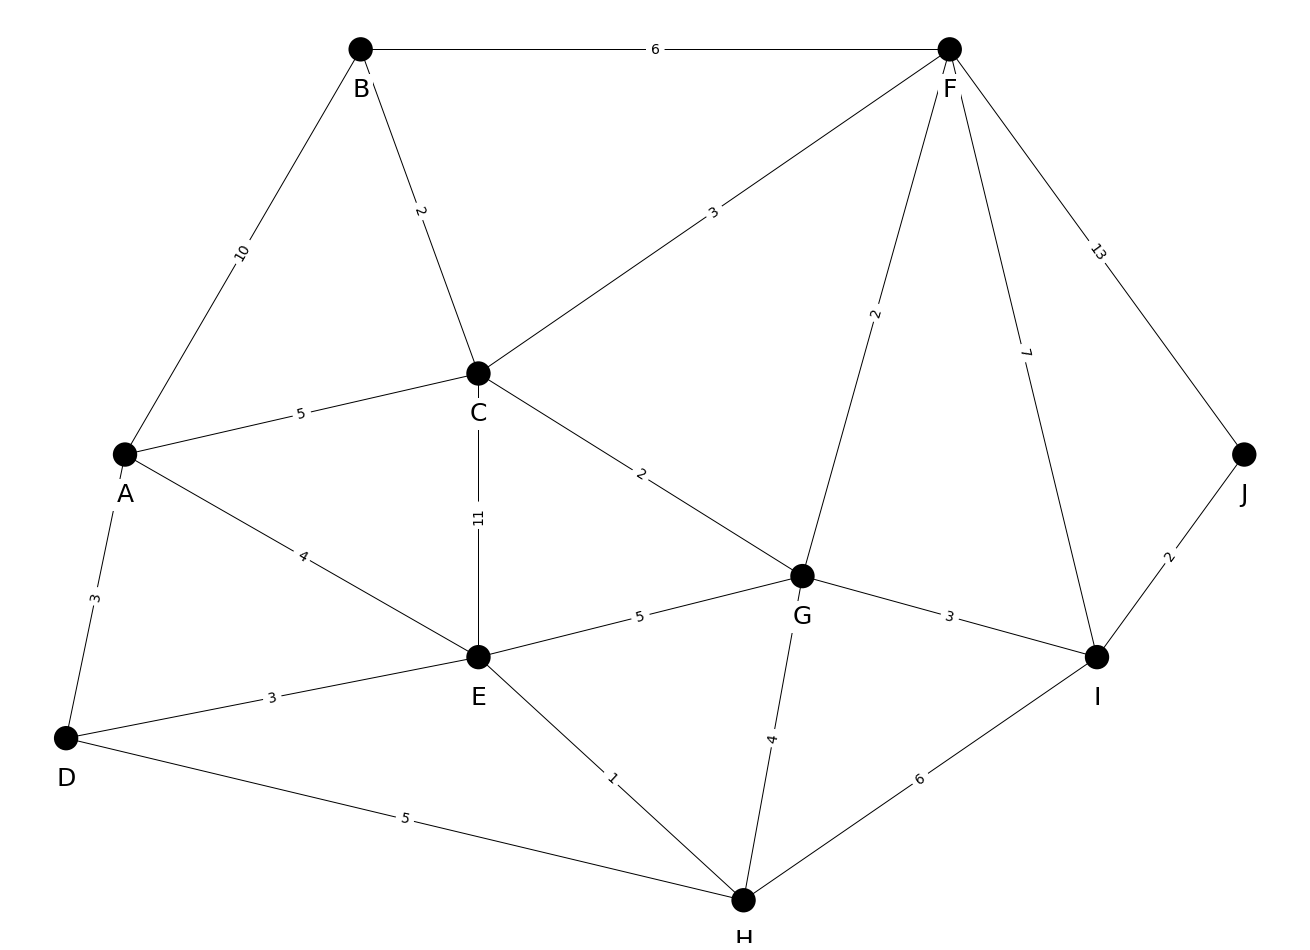

In [115]:
G = nx.Graph(graph_data['graph_dict'])
node_colors = node_colors or graph_data['node_colors']
node_positions = graph_data['node_positions']
node_label_pos = graph_data['node_label_positions']
edge_weights = graph_data['edge_weights']
plt.figure(figsize=(18, 13))
nx.draw(G, pos={k : node_positions[k] for k in G.nodes()}, node_color=[node_colors[node] for node in G.nodes()], linewidths=2, edgecolors='k', node_size = 500)
node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=25)
[label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]
nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)
plt.show()
